In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import linear_model
from scipy.optimize import curve_fit

# Solving the Non-Linear Schrödinger Equation

In the reference frame moving with the group velocity of waves, the Non-Linear Schrödinger equation for the envelope $u$ of 1D deep-water ocean surgace gravity waves is
$$i \partial_t u =\frac{\omega_0}{8k_0^2}\partial_{xx} u+\frac{1}{2}\omega_0 k_0^2 |u|^2 u \, , $$

where $\omega_0$ and $k_0$ are the peak pulse and wavenumber of the wave field which is represented as the real part of $u(x,t)\exp i\left(\omega_0 t -k_0 x \right)$, where $x$ is position and $t$ time.

This equation can be non-dimensionalized setting $T=\omega_0 t$, $X=2\sqrt{2}k_0 x$, $U= \frac{k_0}{\sqrt{2}} u$, giving

$$ i\partial_T U = \partial_{XX} U + |U|^2U \, . $$

It will be solved using a pseudo-spectral scheme (see https://en.wikipedia.org/wiki/Pseudo-spectral_method) as is done in Adcock & Taylor (2009, see section 2 for details on the equation and section 3 for details concerning the numerical integration). The shape of the Gaussian wavenumber spectrum is fitted to a JONSWAP spectrum with $\gamma=3.3$ as in Gibbs & Taylor (2005).

### References

   Adcock, T. A. A., & Taylor, P. H. (2009). Focusing of unidirectional wave groups on deep water: an approximate nonlinear Schrödinger equation-based model. *Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences*, 465(2110), 3083-3102.
   
   Gibbs, R. H., & Taylor, P. H. (2005). Formation of walls of water in ‘fully’nonlinear simulations. Applied Ocean Research, 27(3), 142-157.

## RK4

In [2]:
## 4th-order explicit Runge-Kutta solver for time-independant ODE ##
def RK4(yt,h,f):
    k1=h*f(yt)
    k2=h*f(yt+0.5*k1)
    k3=h*f(yt+0.5*k2)
    k4=h*f(yt+k3)
    dy=(k1+2*k2+2*k3+k4)/6
    return yt+dy
#    return yt+k1

## Settings for the equation

In [3]:
## Physical parameters ##
tp=12 #(s) peak period
grav=9.81 # (m/s^2) gravity acceleration at the earth's surface
w0=2*np.pi/tp # (s^-1) peak pulse
k0=(w0**2)/grav # (m^-1) peak wavenumber
lbda0=2*np.pi/k0 # (m) peak wavelength

In [4]:
## Domain ##
# Spatial #
dx=10; dX=2*np.sqrt(2)*k0*dx # Spatial discretization
Nx=2**12 # Number of points in space (=number of Fourier modes)
Nlbda=Nx*dx/lbda0 # Number of peak wavelength in the spatial domain
X_axis=np.arange(-dX*Nx/2,dX*Nx/2,dX)
# Temporal #
#Nper=2*1500 # Number of peak period in the temporal domain
Nper=65 # Number of peak period in the temporal domain
dt=0.14; dT=w0*dt # Temporal discretization
Nt=round((Nper+1)*tp/dt)
T_axis=np.arange(0,Nt*dT,dT)

In [5]:
dx,dt,2*np.max(X_axis)/(2*np.sqrt(2)*k0),w0,k0

(10, 0.14, 40940.000000008804, 0.5235987755982988, 0.027946552274009957)

In [6]:
## Checking ##
print(len(X_axis),Nx,dX)
print(Nlbda)
print(len(T_axis),Nt,dT)
print(Nper)

4096 4096 0.7904478649494708
182.18319613070267
5657 5657 0.07330382858376185
65


## Initialization

In [7]:
C=np.zeros((Nt,Nx),np.complex64) # Fourier modes for U

Start from a linearly back-propagated Gaussian wave packet :

In [8]:
## Back-propagated Gaussian packet ##
sig=2*np.sqrt(2)*5  # sig = 2sqrt(2)*LfkO
A=np.sqrt(2)*(2**0.25)/sig
phi0=0#2*np.pi*np.random.rand()  # uniform phase
U00=A*np.exp(-X_axis**2/(2*sig**2))*np.exp(1j*phi0)
C00=np.fft.fft(U00)
Delta_T=4*(-0.5*sig**2) # (-0.5*sig**2) corresponds to om0*tau for the article on GWP
                        # and crest velocities

OmNxdX=-(2*np.pi*np.fft.fftfreq(Nx,dX))**2    
                                    # -> This formula for the dispertion relation
                                    # for the envelope is true in the narrow-band limit
                                    # that is used for the NLSE
                                    # and in the reference frame
                                    # moving with the group-velocity
    
C0=C00*np.exp(-1j*OmNxdX*Delta_T)

U0=np.fft.ifft(C0)
C[0,:]=C0

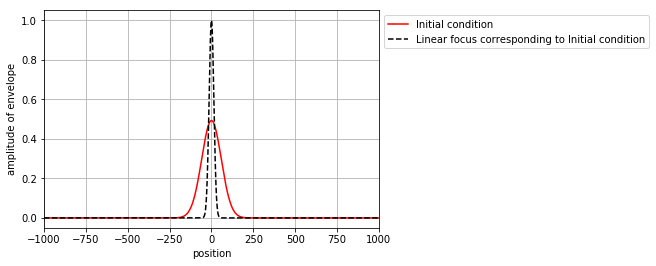

In [9]:
plt.clf()
plt.plot(X_axis,np.abs(U0)/A,'r',label='Initial condition')
plt.plot(X_axis,np.abs(U00)/A,'--k',label='Linear focus corresponding to Initial condition')
plt.legend(bbox_to_anchor=(1, 1)); plt.xlabel("position"); plt.ylabel('amplitude of envelope')
#plt.xlim([-200,200]);
plt.xlim([-1000,1000]);
plt.grid(); plt.show()

In [10]:
Delta_T,Nt*dT,Delta_T/(2*np.pi),Delta_T/dT

(-400.00000000000006,
 414.67975829834074,
 -63.66197723675815,
 -5456.740906007841)

Adcock and Taylor (2009) showed that $2^{1/4}$ and $2^{3/4}$ are important thresholds for the ratio (Spectral Amplitude)/(Spectral bandwidth) as far as the behaviour of the wave packet is concerned (actually $2^{1/4}$ is not a real threshold). The next line helps knowing in which region we are.

In [11]:
## Comparing sig*A, 2^(1/4) and 2^(3/4) ##
sig*A,[2**0.25,2**0.75]

(1.6817928305074292, [1.189207115002721, 1.681792830507429])

In [12]:
## Adimensional amplitude at linear focus a*k_p, H/L ##
print('LINEAR amplitude at linear focus')
print('ak_p='+str(A*np.sqrt(2)))
print('H/L='+str(A*np.sqrt(2)/np.pi))
print('1/7='+str(1/7))

LINEAR amplitude at linear focus
ak_p=0.16817928305074292
H/L=0.053533128446353495
1/7=0.14285714285714285


## Defining the equation to be solved
/!\ WARNING : if $N_x$ or $dX$ is changed, the equation must be redefined before solving.

In [13]:
## Function for integration of the NLSE in Fourier space ##
def NLS_spec(c_t):
    u_t=np.fft.ifft(c_t)
    c_prime_t=np.fft.fft((np.abs(u_t)**2)*u_t)
    return 1j*( ((2*np.pi*np.fft.fftfreq(Nx,dX))**2)*c_t - c_prime_t ) # original
#    return -1j*( ((2*np.pi*np.fft.fftfreq(Nx,dX))**2)*c_t - c_prime_t ) # opposite sign
#    return 1j*( ((2*np.pi*np.fft.fftfreq(Nx,dX))**2)*c_t ) # only propagation

In [14]:
Nt,int(Nt/100)

(5657, 56)

## Solving

In [15]:
## Integration of the NLSE ##
temps_depart=time.time()
for i in range(Nt-1):
    C[i+1,:]=RK4(C[i,:],dT,NLS_spec)
    if (i%int(Nt/100))==0:
        print('i/Nt='+str(int(100*i/Nt))
    +'%, computing time = '+str(int(round(time.time()-temps_depart,0)))+'s')
temps_sim=time.time()-temps_depart
print('Numerical integration time = '+str(round(temps_sim,2))+'s')

i/Nt=0%, computing time = 0s
i/Nt=0%, computing time = 0s
i/Nt=1%, computing time = 1s
i/Nt=2%, computing time = 1s
i/Nt=3%, computing time = 1s
i/Nt=4%, computing time = 1s
i/Nt=5%, computing time = 2s
i/Nt=6%, computing time = 2s
i/Nt=7%, computing time = 2s
i/Nt=8%, computing time = 3s
i/Nt=9%, computing time = 3s
i/Nt=10%, computing time = 3s
i/Nt=11%, computing time = 4s
i/Nt=12%, computing time = 4s
i/Nt=13%, computing time = 4s
i/Nt=14%, computing time = 4s
i/Nt=15%, computing time = 5s
i/Nt=16%, computing time = 5s
i/Nt=17%, computing time = 5s
i/Nt=18%, computing time = 6s
i/Nt=19%, computing time = 6s
i/Nt=20%, computing time = 6s
i/Nt=21%, computing time = 7s
i/Nt=22%, computing time = 7s
i/Nt=23%, computing time = 7s
i/Nt=24%, computing time = 8s
i/Nt=25%, computing time = 8s
i/Nt=26%, computing time = 8s
i/Nt=27%, computing time = 8s
i/Nt=28%, computing time = 9s
i/Nt=29%, computing time = 9s
i/Nt=30%, computing time = 9s
i/Nt=31%, computing time = 10s
i/Nt=32%, computing 

In [16]:
amp_max_nonlin=np.max(np.abs(np.fft.ifft(C)))
## Adimensional amplitude at non-linear focus a*k_p, H/L ##
print('NONLINEAR amplitude at nonlinear focus')
print('ak_p='+str(amp_max_nonlin*np.sqrt(2)))
print('H/L='+str(amp_max_nonlin*np.sqrt(2)/np.pi))
print('1/7='+str(1/7))

NONLINEAR amplitude at nonlinear focus
ak_p=0.23471239000712282
H/L=0.07471127414909276
1/7=0.14285714285714285


## Interpolation and cutting
Interpolating in $x$-space and leaving the useless parts of data.

*In time* (cutting)

In [17]:
np.argmax(np.amax(np.abs(np.fft.ifft(C)[4000:,:]),axis=1))

670

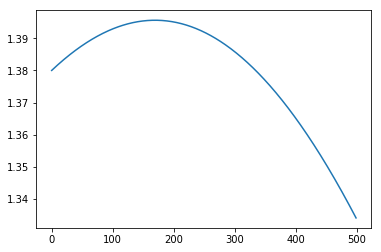

In [19]:
plt.clf()
plt.plot(np.amax(np.abs(np.fft.ifft(C)[4500:5000,:]),axis=1)/A)
plt.show()

In [20]:
np.amax(np.abs(np.fft.ifft(C)[4669,:]))/A,np.amax(np.abs(np.fft.ifft(C)[4670,:]))/A,np.amax(np.abs(np.fft.ifft(C)[4671,:]))/A,

(1.3956073907933633, 1.3956073972479757, 1.395606265339216)

In [17]:
#nt1=1240; nt2=4670;dnt=1
#nt1=1240+2200; nt2=4670-1031; nt3=4670;dnt=1
nt1=1240+2480-20; nt2=1240+2480+20; nt3=4670;dnt=1
nt1=1240; nt2=4670; nt3=4670;dnt=1
#(T_axis[nt1:nt2+1:dnt]-T_axis[nt2])/(2*np.pi),len(T_axis)
(T_axis[nt1:nt2+1:dnt]-T_axis[nt3])/(2*np.pi),len(T_axis)

(array([-4.00166667e+01, -4.00050000e+01, -3.99933333e+01, ...,
        -2.33333333e-02, -1.16666667e-02,  0.00000000e+00]), 5657)

In [18]:
#t_axis=(T_axis[nt1:nt2+1:dnt]-T_axis[nt2])/w0
t_axis=(T_axis[nt1:nt2+1:dnt]-T_axis[nt3])/w0

*In space* (interpolating and cutting)

In [19]:
from scipy import interpolate

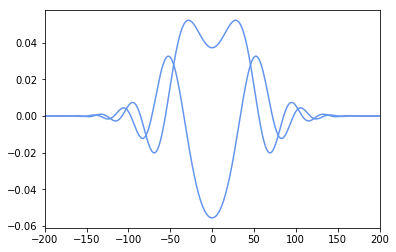

In [20]:
n=nt1;plt.clf()
plt.plot(X_axis,np.real(np.fft.ifft(C[n,:])),color='cornflowerblue')
plt.plot(X_axis,np.imag(np.fft.ifft(C[n,:])),color='cornflowerblue')
plt.xlim(-200,200)
plt.show()

In [21]:
scale=300
dx_new=dx/scale; dX_new=dX/scale
#X_axis_new=np.arange(-dX*Nx/2,dX*Nx/2,dX_new)
X_axis_new=np.arange(-75,75,dX_new)

In [22]:
#x_axis=X_axis_new[nx1:nx2+1]/(2*np.sqrt(2)*k0)
x_axis=X_axis_new/(2*np.sqrt(2)*k0)

In [23]:
#int(Nx*scale),Nx*scale,len(X_axis_new),X_axis_new[0],X_axis_new[-1],X_axis_new[-2],dX*Nx/2,dX*Nx/2+dX_new
Nx,len(X_axis_new),X_axis_new[0],X_axis_new[-1]

(4096, 56930, -75.0, 74.99802167873139)

In [24]:
temps_depart=time.time()
U_new=np.zeros((nt2-nt1+1,len(X_axis_new)),np.complex64)
for n in range(nt1,nt2+1):
    tck_re=interpolate.splrep(X_axis,np.real(np.fft.ifft(C[n,:])),s=0)
    tck_im=interpolate.splrep(X_axis,np.imag(np.fft.ifft(C[n,:])),s=0)
    U_new[n-nt1,:]=interpolate.splev(X_axis_new,tck_re,der=0)+1j*interpolate.splev(X_axis_new,tck_im,der=0)
temps_interp=time.time()-temps_depart

In [25]:
temps_interp/60,nt2-nt1+1

(1.6482115864753724, 3431)

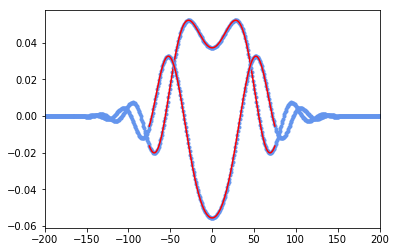

In [26]:
n=0;plt.clf()
plt.plot(X_axis,np.real(np.fft.ifft(C[n+nt1,:])),'.',color='cornflowerblue')
plt.plot(X_axis_new,np.real(U_new[n,:]),'-r')
plt.plot(X_axis,np.imag(np.fft.ifft(C[n+nt1,:])),'.',color='cornflowerblue')
plt.plot(X_axis_new,np.imag(U_new[n,:]),'-r')
plt.xlim(-200,200)
#plt.xlim(-50,50)
#plt.xlim(-5,5)
#plt.xlim(50,60)
plt.show()

In [27]:
temps_depart=time.time()
# Recalculating the associated sea-surface elevation
eta1=np.real( (( (np.sqrt(2)/k0) * U_new * np.exp(1j*k0*x_axis) ).T)
             *np.exp(1j*(-0.5*T_axis[nt1:nt2+1:dnt])) )
temps_sse=time.time()-temps_depart

In [28]:
temps_sse,dt,nt2-nt1+1

(13.604753017425537, 0.14, 3431)


## Crest velocities

In [29]:
par2om=-w0/(4*k0**2)
L=sig/(2*np.sqrt(2)*k0)
tau=L**2/par2om
c0=w0/k0
cg0=w0/(2*k0)
ccr_1ord=cg0+0.5*k0*par2om-c0
ccr_grad_1ord=(-c0+cg0)*k0*t_axis/tau
ccr_2ord=c0-cg0-0.5*k0*par2om
ccr_grad_2ord=k0*(1.5*par2om*k0+4*c0-4*cg0)*t_axis/tau
ccr_lapl_2ord=2*((c0-cg0+0.5*k0*par2om)*(t_axis/tau)**2-0.5*k0*par2om)*(k0)**2
Spread_x=np.sqrt(L**2+(L**(-2))*(par2om*t_axis)**2)
c_grad_expect=ccr_grad_1ord[:-2]/((k0*Spread_x[:-2])**2)+0.5*ccr_grad_2ord[:-2]/((k0*Spread_x[:-2])**4)

In [30]:
from scipy.signal import argrelextrema

In [31]:
temps_depart=time.time()
extrema2=argrelextrema(np.abs(eta1.T), np.greater, axis=1)
extrema=[]
for k in range(len(extrema2[0])):
    extrema.append([extrema2[1][k],extrema2[0][k]])
temps_extr2=time.time()-temps_depart

In [32]:
temps_extr2/60,len(extrema),nt2-nt1+1

(0.2487676461537679, 59218, 3431)

In [37]:
np.max(eta1*k0/(A*np.sqrt(2)))

1.3878001439220031

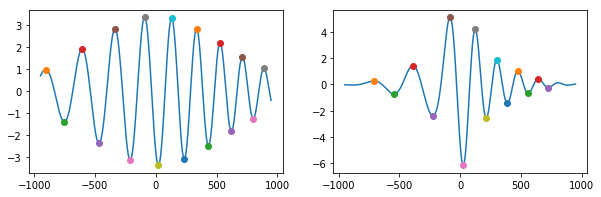

In [38]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(121)
n=20
ax.plot(x_axis,eta1[:,n])
for m in range(len(extrema)):
    if extrema[m][1]==n:
        ax.plot(x_axis[extrema[m][0]],eta1[extrema[m][0],n],'o')
ax=fig.add_subplot(122)
n=2400
ax.plot(x_axis,eta1[:,n])
for m in range(len(extrema)):
    if extrema[m][1]==n:
        ax.plot(x_axis[extrema[m][0]],eta1[extrema[m][0],n],'o')
fig.set_size_inches([10,3])
plt.show()

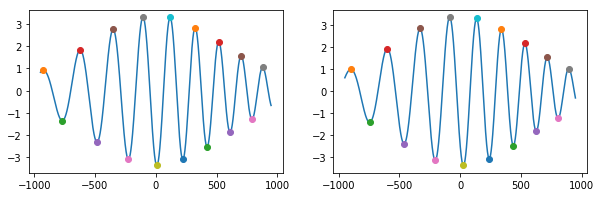

In [39]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(121)
n=10
ax.plot(x_axis,eta1[:,n])
for m in range(len(extrema)):
    if extrema[m][1]==n:
        ax.plot(x_axis[extrema[m][0]],eta1[extrema[m][0],n],'o')
ax=fig.add_subplot(122)
n=24
ax.plot(x_axis,eta1[:,n])
for m in range(len(extrema)):
    if extrema[m][1]==n:
        ax.plot(x_axis[extrema[m][0]],eta1[extrema[m][0],n],'o')
fig.set_size_inches([10,3])
plt.show()

In [33]:
temps_depart=time.time()
nmoy=15 # number of time-steps over which the mean velicity is computed
extr_speed1=np.zeros(len(extrema))
for m in range(len(extrema)):
    if (m%int(len(extrema)/100))==0:
        print('computing='+str(int(100*m/len(extrema)))
    +'%, computing time = '+str(int(round(time.time()-temps_depart,0)))+'s')
    i=extrema[m][0]; n=extrema[m][1]
    signe=np.sign(eta1[i,n])
    if n<=nmoy:
        i2=False
        for m2 in range(m,len(extrema)):
            if ( extrema[m2][1]==n+nmoy and extrema[m2][0]-i>0 
                    and np.sign(eta1[extrema[m2][0],extrema[m2][1]])==signe ):
                i2=extrema[m2][0]
                break
        if i2:
            extr_speed1[m]=(x_axis[i2]-x_axis[i])/(nmoy*dt*dnt)
        else:
            extr_speed1[m]=np.nan
    else:
        for m2 in range(len(extrema)):
            if ( extrema[m-m2][1]==n-nmoy and extrema[m-m2][0]-i<=0
                    and np.sign(eta1[extrema[m-m2][0],extrema[m-m2][1]])==signe ):
                i2=extrema[m-m2][0]
                break
        if i2:
            extr_speed1[m]=(x_axis[i]-x_axis[i2])/(nmoy*dt*dnt)
        else:
            extr_speed1[m]=np.nan
temps_speed=time.time()-temps_depart  

computing=0%, computing time = 0s
computing=0%, computing time = 2s
computing=1%, computing time = 2s
computing=2%, computing time = 2s
computing=3%, computing time = 3s
computing=4%, computing time = 4s
computing=5%, computing time = 5s
computing=6%, computing time = 5s
computing=7%, computing time = 6s
computing=8%, computing time = 7s
computing=9%, computing time = 7s
computing=10%, computing time = 8s
computing=11%, computing time = 8s
computing=12%, computing time = 9s
computing=13%, computing time = 10s
computing=14%, computing time = 10s
computing=15%, computing time = 11s
computing=16%, computing time = 12s
computing=17%, computing time = 12s
computing=18%, computing time = 13s
computing=19%, computing time = 13s
computing=20%, computing time = 15s
computing=21%, computing time = 15s
computing=22%, computing time = 15s
computing=23%, computing time = 16s
computing=24%, computing time = 16s
computing=25%, computing time = 18s
computing=26%, computing time = 18s
computing=27%, co

In [34]:
temps_speed,nt2-nt1+1

(64.92338633537292, 3431)

In [35]:
dt*dnt*nmoy/(2*np.pi/w0),dx_new/(nmoy*dt*dnt),(c0/2)/(L*k0)**2,(dx_new/(nmoy*dt*dnt))/((c0/2)/(L*k0)**2)

(0.17500000000000002,
 0.015873015873015872,
 0.37471439801555845,
 0.042360304159854596)

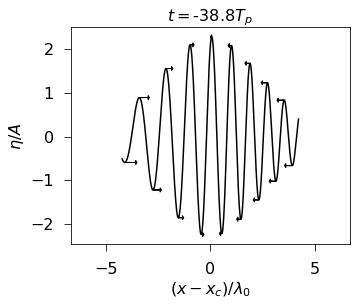

In [43]:
n=100
plt.clf(); fig=plt.figure(); fig.add_axes()

ax=fig.add_subplot(111)
ax.plot(x_axis*k0/(2*np.pi),2*np.sqrt(2)*k0*eta1[:,n]/A,'-k',label="Group elevation")
for m in range(len(extrema)):
    if extrema[m][1]==n:
        arrow=ax.arrow(x_axis[extrema[m][0]]*k0/(2*np.pi),2*np.sqrt(2)*k0*eta1[extrema[m][0],n]/A,
                       30*(extr_speed1[m]-c0/2)*k0/(2*np.pi),0,
          head_width=0.1, head_length=15*k0/(2*np.pi), fc='k', ec='k')
ax.plot([0,0],[0,0],'-k',label="$c_{cr}-c_0$ (numerical)")

ax.set_xlabel('$(x-x_c)/\lambda_0$',fontsize=16);
ax.set_ylabel('$\eta/A$',fontsize=16); #ax.legend(bbox_to_anchor=(1-0.006, 0.01), loc='lower right', borderaxespad=0.,fontsize=12)
plt.title('$t=$'+str(t_axis[n]*k0*c0/(2*np.pi))[0:5]+'$T_p$',fontsize=16)
ax.set_xlim(-1500*k0/(2*np.pi),1500*k0/(2*np.pi)); #ax.set_ylim(-1.1,1.1)
fig.set_size_inches(5,4)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)

plt.show()

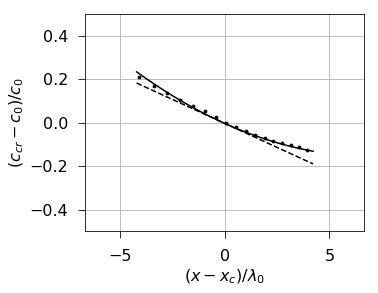

In [44]:
n=100
scaling=1
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2)
           +(ccr_grad_2ord[n]*x_axis+0.5*ccr_lapl_2ord[n]*x_axis**2)/((k0*Spread_x[n])**4))/c0,'k')
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2))/c0,'--k')
for m in range(len(extrema)):
    if extrema[m][1]==n:
        ax.plot(x_axis[extrema[m][0]]*k0/(2*np.pi),scaling*(extr_speed1[m]-c0/2)/c0,'ok',markersize=2.8,label='c1='+str(extr_speed1[m]))
ax.set_ylim(-0.5,0.5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('$(x-x_c)/\lambda_0$',fontsize=16);
ax.set_ylabel("$(c_{cr}-c_0)/c_0$",fontsize=16);
ax.set_xlim(-1500*k0/(2*np.pi),1500*k0/(2*np.pi));#ax.set_ylim(-0.4,0.4)
plt.grid()
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches(5,4)
plt.show()

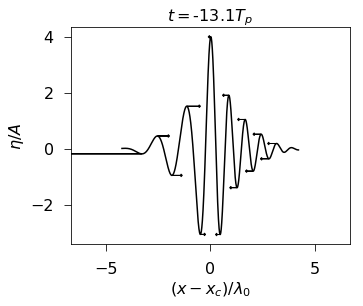

In [45]:
n=2300
plt.clf(); fig=plt.figure(); fig.add_axes()

ax=fig.add_subplot(111)
ax.plot(x_axis*k0/(2*np.pi),2*np.sqrt(2)*k0*eta1[:,n]/A,'-k',label="Group elevation")
for m in range(len(extrema)):
    if extrema[m][1]==n:
        arrow=ax.arrow(x_axis[extrema[m][0]]*k0/(2*np.pi),2*np.sqrt(2)*k0*eta1[extrema[m][0],n]/A,
                       30*(extr_speed1[m]-c0/2)*k0/(2*np.pi),0,
          head_width=0.1, head_length=15*k0/(2*np.pi), fc='k', ec='k')
ax.plot([0,0],[0,0],'-k',label="$c_{cr}-c_0$ (numerical)")

ax.set_xlabel('$(x-x_c)/\lambda_0$',fontsize=16);
ax.set_ylabel('$\eta/A$',fontsize=16); #ax.legend(bbox_to_anchor=(1-0.006, 0.01), loc='lower right', borderaxespad=0.,fontsize=12)
plt.title('$t=$'+str(t_axis[n]*k0*c0/(2*np.pi))[0:5]+'$T_p$',fontsize=16)
ax.set_xlim(-1500*k0/(2*np.pi),1500*k0/(2*np.pi)); #ax.set_ylim(-1.1,1.1)
fig.set_size_inches(5,4)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)

plt.show()

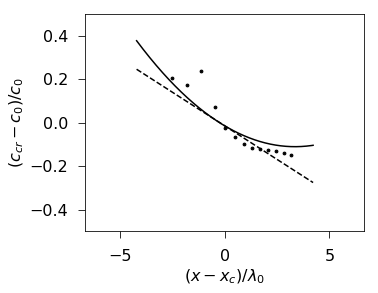

In [46]:
n=2300
scaling=1
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2)
           +(ccr_grad_2ord[n]*x_axis+0.5*ccr_lapl_2ord[n]*x_axis**2)/((k0*Spread_x[n])**4))/c0,'k')
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2))/c0,'--k')
for m in range(len(extrema)):
    if extrema[m][1]==n:
        ax.plot(x_axis[extrema[m][0]]*k0/(2*np.pi),scaling*(extr_speed1[m]-c0/2)/c0,'ok',markersize=2.8,label='c1='+str(extr_speed1[m]))
ax.set_ylim(-0.5,0.5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('$(x-x_c)/\lambda_0$',fontsize=16);
ax.set_ylabel("$(c_{cr}-c_0)/c_0$",fontsize=16);
ax.set_xlim(-1500*k0/(2*np.pi),1500*k0/(2*np.pi));#ax.set_ylim(-0.4,0.4)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches(5,4)
plt.show()

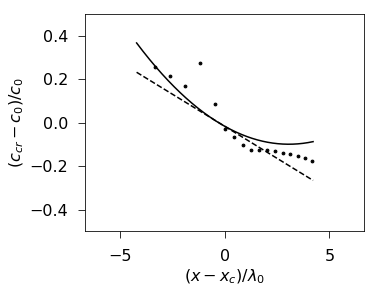

In [93]:
n=20
scaling=1
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2)
           +(ccr_grad_2ord[n]*x_axis+0.5*ccr_lapl_2ord[n]*x_axis**2)/((k0*Spread_x[n])**4))/c0,'k')
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2))/c0,'--k')
for m in range(len(extrema)):
    if extrema[m][1]==n:
        ax.plot(x_axis[extrema[m][0]]*k0/(2*np.pi),scaling*(extr_speed1[m]-c0/2)/c0,'ok',markersize=2.8,label='c1='+str(extr_speed1[m]))
ax.set_ylim(-0.5,0.5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('$(x-x_c)/\lambda_0$',fontsize=16);
ax.set_ylabel("$(c_{cr}-c_0)/c_0$",fontsize=16);
ax.set_xlim(-1500*k0/(2*np.pi),1500*k0/(2*np.pi));#ax.set_ylim(-0.4,0.4)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches(5,4)
plt.show()

In [94]:
dx_new/(nmoy*dt*dnt),(c0/2)/(L*k0)**2,(dx_new/(nmoy*dt*dnt))/((c0/2)/(L*k0)**2)

(0.015873015873015872, 0.37471439801555845, 0.042360304159854596)

#### Iteration for Fig1bis

In [95]:
nn=20; x_ccr=[]; ccr_adim=[]; t_adim=t_axis[nn]*k0*c0/(2*np.pi)

In [96]:
temps_depart=time.time()
DPHI=np.linspace(0,2*np.pi,num=25)
avancement=0
for dphi in DPHI:
    if(100*dphi/DPHI[-1])>avancement:
        avancement=int(100*dphi/DPHI[-1])+1
        print('Calculation '+str(avancement)+'% complete, time='
              +str((time.time()-temps_depart)/60)[0:3]+'min')
    #interpolated envelope
    U_new=np.zeros((nt2-nt1+1,len(X_axis_new)),np.complex64) 
    for n in range(nt1,nt2+1):
        tck_re=interpolate.splrep(X_axis,np.real(np.fft.ifft(C[n,:]*np.exp(1j*dphi))),s=0)
        tck_im=interpolate.splrep(X_axis,np.imag(np.fft.ifft(C[n,:]*np.exp(1j*dphi))),s=0)
        U_new[n-nt1,:]=interpolate.splev(X_axis_new,tck_re,der=0)+1j*interpolate.splev(X_axis_new,tck_im,der=0)

    # Recalculating the associated sea-surface elevation
    eta1=np.real( (( (np.sqrt(2)/k0) * U_new * np.exp(1j*k0*x_axis) ).T)
                 *np.exp(1j*(-0.5*T_axis[nt1:nt2+1:dnt])) )

    extrema2=argrelextrema(np.abs(eta1.T), np.greater, axis=1)
    extrema=[]
    for k in range(len(extrema2[0])):
        extrema.append([extrema2[1][k],extrema2[0][k]])

    # compute velocity
    nmoy=15 # number of time-steps over which the mean velicity is computed
    extr_speed1=np.zeros(len(extrema))
    for m in range(len(extrema)):
        i=extrema[m][0]; n=extrema[m][1]
        signe=np.sign(eta1[i,n])
        if n<=nmoy:
            i2=False
            for m2 in range(m,len(extrema)):
                if ( extrema[m2][1]==n+nmoy and extrema[m2][0]-i>0 
                        and np.sign(eta1[extrema[m2][0],extrema[m2][1]])==signe ):
                    i2=extrema[m2][0]
                    break
            if i2:
                extr_speed1[m]=(x_axis[i2]-x_axis[i])/(nmoy*dt*dnt)
            else:
                extr_speed1[m]=np.nan
        else:
            for m2 in range(len(extrema)):
                if ( extrema[m-m2][1]==n-nmoy and extrema[m-m2][0]-i<=0
                        and np.sign(eta1[extrema[m-m2][0],extrema[m-m2][1]])==signe ):
                    i2=extrema[m-m2][0]
                    break
            if i2:
                extr_speed1[m]=(x_axis[i]-x_axis[i2])/(nmoy*dt*dnt)
            else:
                extr_speed1[m]=np.nan

    # store the results
    for m in range(len(extrema)):
        if extrema[m][1]==nn:
            x_ccr.append(x_axis[extrema[m][0]]*k0/(2*np.pi))
            ccr_adim.append((extr_speed1[m]-c0/2)/c0)
temps_fig1bis=time.time()-temps_depart

Calculation 5% complete, time=0.0min
Calculation 9% complete, time=0.0min
Calculation 13% complete, time=0.0min
Calculation 17% complete, time=0.1min
Calculation 21% complete, time=0.1min
Calculation 26% complete, time=0.1min
Calculation 30% complete, time=0.1min
Calculation 34% complete, time=0.2min
Calculation 38% complete, time=0.2min
Calculation 42% complete, time=0.2min
Calculation 46% complete, time=0.3min
Calculation 51% complete, time=0.3min
Calculation 55% complete, time=0.3min
Calculation 59% complete, time=0.3min
Calculation 63% complete, time=0.4min
Calculation 67% complete, time=0.4min
Calculation 71% complete, time=0.4min
Calculation 76% complete, time=0.5min
Calculation 80% complete, time=0.5min
Calculation 84% complete, time=0.5min
Calculation 88% complete, time=0.5min
Calculation 92% complete, time=0.6min
Calculation 96% complete, time=0.6min
Calculation 101% complete, time=0.6min


In [97]:
temps_fig1bis/60,len(DPHI)

(0.7004116813341776, 25)

In [98]:
x_ccr=np.array(x_ccr);ccr_adim=np.array(ccr_adim)

In [99]:
index=np.argsort(x_ccr)
x_ccr=x_ccr[index];ccr_adim=ccr_adim[index]

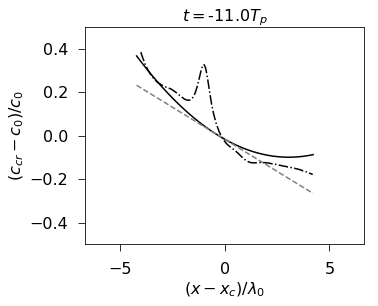

In [100]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[nn]*x_axis)/((k0*Spread_x[nn])**2)
           +(ccr_grad_2ord[nn]*x_axis+0.5*ccr_lapl_2ord[nn]*x_axis**2)/((k0*Spread_x[nn])**4))/c0,'k')
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[nn]*x_axis)/((k0*Spread_x[nn])**2))/c0,'--',color='grey')
ax.plot(x_ccr[6:],ccr_adim[6:],'-.k')
ax.set_ylim(-0.5,0.5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('$(x-x_c)/\lambda_0$',fontsize=16);
ax.set_ylabel("$(c_{cr}-c_0)/c_0$",fontsize=16);
plt.title('$t=$'+str(t_axis[nn]*k0*c0/(2*np.pi))[0:5]+'$T_p$',fontsize=16)
ax.set_xlim(-1500*k0/(2*np.pi),1500*k0/(2*np.pi));#ax.set_ylim(-0.4,0.4)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches(5,4)
plt.show()

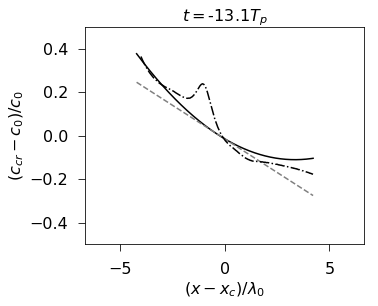

In [54]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2)
           +(ccr_grad_2ord[n]*x_axis+0.5*ccr_lapl_2ord[n]*x_axis**2)/((k0*Spread_x[n])**4))/c0,'k')
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2))/c0,'--',color='grey')
ax.plot(x_ccr[4:],ccr_adim[4:],'-.k')
ax.set_ylim(-0.5,0.5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('$(x-x_c)/\lambda_0$',fontsize=16);
ax.set_ylabel("$(c_{cr}-c_0)/c_0$",fontsize=16);
plt.title('$t=$'+str(t_axis[n]*k0*c0/(2*np.pi))[0:5]+'$T_p$',fontsize=16)
ax.set_xlim(-1500*k0/(2*np.pi),1500*k0/(2*np.pi));#ax.set_ylim(-0.4,0.4)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches(5,4)
plt.show()

In [102]:
np.savez('c_mes_L5_A0p17.npz',x_ccr=np.array(x_ccr),ccr_adim=np.array(ccr_adim),
         t_adim=t_adim,tau=tau,L=L,alkp=A*np.sqrt(2))

In [101]:
tau*w0/(2*np.pi),t_adim

(-15.91549430918953, -11.083333333333336)

#### For Fig3 bis

In [35]:
c_grad_agg=[];t_grad_agg=[]

In [36]:
temps_depart=time.time()
DPHI=np.linspace(0,2*np.pi,num=4,endpoint=0)
#DPHI=np.array([0.25,0.75,1.63])*np.pi
avancement=0
for dphi in DPHI:
    if(100*dphi/DPHI[-1])>avancement:
        avancement=int(100*dphi/DPHI[-1])+1
        print('Calculation '+str(avancement)+'% complete, time='
              +str((time.time()-temps_depart)/60)[0:3]+'min')
    #interpolated envelope
    U_new=np.zeros((nt2-nt1+1,len(X_axis_new)),np.complex64) 
    for n in range(nt1,nt2+1):
        tck_re=interpolate.splrep(X_axis,np.real(np.fft.ifft(C[n,:]*np.exp(1j*dphi))),s=0)
        tck_im=interpolate.splrep(X_axis,np.imag(np.fft.ifft(C[n,:]*np.exp(1j*dphi))),s=0)
        U_new[n-nt1,:]=interpolate.splev(X_axis_new,tck_re,der=0)+1j*interpolate.splev(X_axis_new,tck_im,der=0)

    # Recalculating the associated sea-surface elevation
    eta1=np.real( (( (np.sqrt(2)/k0) * U_new * np.exp(1j*k0*x_axis) ).T)
                 *np.exp(1j*(-0.5*T_axis[nt1:nt2+1:dnt])) )

    extrema2=argrelextrema(np.abs(eta1.T), np.greater, axis=1)
    extrema=[]
    for k in range(len(extrema2[0])):
        extrema.append([extrema2[1][k],extrema2[0][k]])

    # compute velocity
    nmoy=15 # number of time-steps over which the mean velicity is computed
    extr_speed1=np.zeros(len(extrema))
    for m in range(len(extrema)):
        i=extrema[m][0]; n=extrema[m][1]
        signe=np.sign(eta1[i,n])
        if n<=nmoy:
            i2=False
            for m2 in range(m,len(extrema)):
                if ( extrema[m2][1]==n+nmoy and extrema[m2][0]-i>0 
                        and np.sign(eta1[extrema[m2][0],extrema[m2][1]])==signe ):
                    i2=extrema[m2][0]
                    break
            if i2:
                extr_speed1[m]=(x_axis[i2]-x_axis[i])/(nmoy*dt*dnt)
            else:
                extr_speed1[m]=np.nan
        else:
            for m2 in range(len(extrema)):
                if ( extrema[m-m2][1]==n-nmoy and extrema[m-m2][0]-i<=0
                        and np.sign(eta1[extrema[m-m2][0],extrema[m-m2][1]])==signe ):
                    i2=extrema[m-m2][0]
                    break
            if i2:
                extr_speed1[m]=(x_axis[i]-x_axis[i2])/(nmoy*dt*dnt)
            else:
                extr_speed1[m]=np.nan

    # position of the largest crest/trough in space, over time
    eta_abs_argmax=np.argmax(np.abs(eta1),axis=0)
    # criterion for having the largest crest/trough close enough to the center of the WP
    thresh_center= 4 * ((2*np.pi)/k0) * dt/(2*tp) 
    
    # measuring the center gradient
    c_grad_mes=[]
    t_grad_mes=[]
    dist0=np.max(x_axis)*10**2
    LM=linear_model.LinearRegression()

    for n in range(len(t_axis)):
        if (-thresh_center/2<x_axis[eta_abs_argmax[n]]
            and x_axis[eta_abs_argmax[n]]<thresh_center/2):
        
            t_grad_mes.append(t_axis[n])
        
            m0=0
            dist=dist0
            for m in range(len(extrema)):
                if (extrema[m][1]==n
                    and np.abs(x_axis[extrema[m][0]])<dist):
                    dist=np.abs(x_axis[extrema[m][0]])
                    m0=m
            
            y=np.array([  
                extr_speed1[m0-1] , 
                extr_speed1[m0] ,
                extr_speed1[m0+1]  
                   ])
    
            X=np.array([ 
                [1,x_axis[extrema[m0-1][0]],x_axis[extrema[m0-1][0]]**2] , 
                [1,x_axis[extrema[m0][0]],x_axis[extrema[m0][0]]**2] ,
                [1,x_axis[extrema[m0+1][0]],x_axis[extrema[m0+1][0]]**2] 
                   ])
    
            c_grad_mes.append(LM.fit(X,y).coef_[1])
            del X, y

    c_=[c_grad_mes[0]]
    t_=[t_grad_mes[0]]
    for n in range(len(t_grad_mes)-1):
        if t_grad_mes[n+1]-t_grad_mes[n]<2*dt:
            c_.append(c_grad_mes[n+1])
            t_.append(t_grad_mes[n+1])
        else:
            c_grad_agg.append(np.mean(np.array(c_)))
            t_grad_agg.append(np.mean(np.array(t_)))
            c_=[c_grad_mes[n+1]]
            t_=[t_grad_mes[n+1]]
        if n+1==len(t_grad_mes)-1:
            c_grad_agg.append(np.mean(np.array(c_)))
            t_grad_agg.append(np.mean(np.array(t_)))
    
temps_fig3bis=time.time()-temps_depart

Calculation 34% complete, time=3.4min
Calculation 67% complete, time=6.7min
Calculation 101% complete, time=10.min


In [37]:
temps_fig3bis/60,len(DPHI)

(13.337411157290141, 4)

In [38]:
DPHI/np.pi

array([0. , 0.5, 1. , 1.5])

In [39]:
t_grad_agg=np.array(t_grad_agg); c_grad_agg=np.array(c_grad_agg)

In [40]:
index=np.argsort(t_grad_agg)
t_grad_agg=t_grad_agg[index];c_grad_agg=c_grad_agg[index]

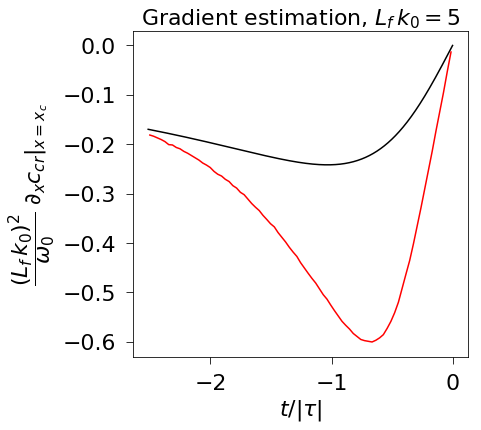

In [41]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(np.array(t_grad_agg)/np.abs(tau),np.array(c_grad_agg)*L*L*k0*k0/(c0*k0),'-r')
#ax.set_xlim([-2,0])
#ax.set_ylim([-1.2,0.1])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

In [42]:
np.savez('c_grad_L5_A0p17_0.npz',t_grad_agg=t_grad_agg,c_grad_agg=c_grad_agg,
         tau=tau,L=L,alkp=A*np.sqrt(2))

In [43]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

/home/administrateur/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


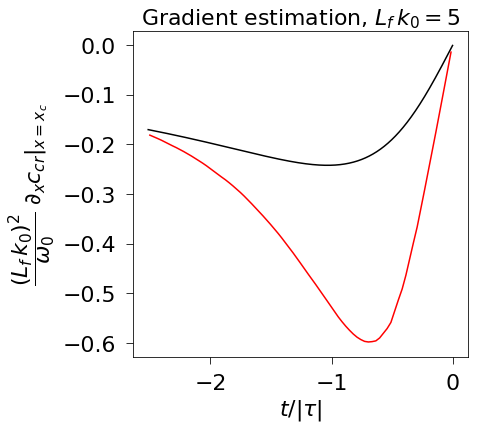

In [63]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(t_grad_agg/np.abs(tau),
        lowess(c_grad_agg*L*L*k0*k0/(c0*k0), t_grad_agg/np.abs(tau),
               frac=1./12, it=3, return_sorted=False),
        '-r')
#ax.set_xlim([-2,0])
#ax.set_ylim([-1.2,0.1])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

In [64]:
n_min=np.argmin(lowess(c_grad_agg*L*L*k0*k0/(c0*k0), t_grad_agg/np.abs(tau),
               frac=1./12, it=3, return_sorted=False))
t_min_adim=t_grad_agg[n_min]/np.abs(tau)

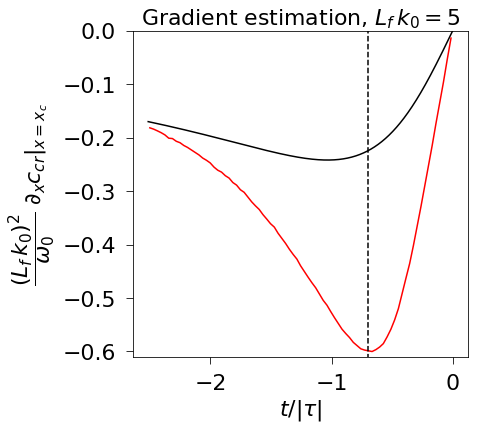

In [65]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(t_grad_agg/np.abs(tau),c_grad_agg*L*L*k0*k0/(c0*k0),'-r')
ax.plot([t_min_adim,t_min_adim],[-1,1],'--k')
#ax.set_xlim([-2,0])
ax.set_ylim([-.61,0])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

In [78]:
t_axis[2480],t_grad_agg[n_min]

(-133.00000000000003, -133.07000000000002)

In [49]:
n=2300
spid=0
for m in range(len(extrema)):
    if extrema[m][1]==n:
        diff=(extr_speed1[m]-spid)/(dx_new/(nmoy*dt*dnt))
        spid=extr_speed1[m]
        print('velocity='+str(spid)+', velocity difference / precision ='+str(diff))

velocity=-682.7142857129353, velocity difference / precision =-43010.99999991493
velocity=13.25396825394207, velocity difference / precision =43845.99999991328
velocity=12.603174603149688, velocity difference / precision =-40.999999999920064
velocity=13.793650793623522, velocity difference / precision =74.99999999985157
velocity=10.761904761883477, velocity difference / precision =-190.99999999962287
velocity=8.920634920617276, velocity difference / precision =-115.99999999977062
velocity=8.174603174587004, velocity difference / precision =-46.999999999907175
velocity=7.571428571413605, velocity difference / precision =-37.99999999992411
velocity=7.206349206334965, velocity difference / precision =-22.999999999954372
velocity=7.126984126970038, velocity difference / precision =-4.999999999990358
velocity=7.047619047605085, velocity difference / precision =-4.999999999992037
velocity=6.920634920621209, velocity difference / precision =-7.999999999984192
velocity=6.777777777764359, veloc

In [51]:
temps_depart=time.time()

c_grad_mes_spl=np.zeros(len(t_axis)-2)
c_spl=[]
dist0=np.max(x_axis)*10**2
LM=linear_model.LinearRegression()
xnew=np.arange(-np.pi/k0,np.pi/k0,(2*np.pi/k0)/50)
for n in range(len(t_axis)-2):
    if (n%int((len(t_axis)-2)/100))==0:
        print('computing='+str(int(100*n/(len(t_axis)-2)))
    +'%, computing time = '+str(int(round(time.time()-temps_depart,0)))+'s')
    m0=0
    dist=dist0
    for m in range(len(extrema)):
        if (extrema[m][1]==n
            and np.abs(x_axis[extrema[m][0]])<dist):
            dist=np.abs(x_axis[extrema[m][0]])
            m0=m
            
    y=np.array([  
                extr_speed1[m0-2] , 
                extr_speed1[m0-1] , 
                extr_speed1[m0] ,
                extr_speed1[m0+1],
                extr_speed1[m0+2]  
               ])
    
    x=np.array([ 
                [x_axis[extrema[m0-2][0]]],
                [x_axis[extrema[m0-1][0]]],
                [x_axis[extrema[m0][0]]],
                [x_axis[extrema[m0+1][0]]],
                [x_axis[extrema[m0+2][0]]]
               ])
    
    interpol=interpolate.splrep(x,y)
    ynew=interpolate.splev(xnew,interpol,der=0)
    
    c_grad_mes_spl[n]=LM.fit(np.array([xnew]).T,ynew).coef_[0]
    c_spl.append(ynew)
    del x, y, ynew
temps_grad=time.time()-temps_depart  

computing=0%, computing time = 0s
computing=0%, computing time = 2s
computing=1%, computing time = 3s
computing=2%, computing time = 5s
computing=3%, computing time = 7s
computing=4%, computing time = 8s
computing=5%, computing time = 10s
computing=6%, computing time = 12s
computing=7%, computing time = 13s
computing=8%, computing time = 15s
computing=9%, computing time = 17s
computing=10%, computing time = 19s
computing=11%, computing time = 20s
computing=12%, computing time = 22s
computing=13%, computing time = 24s
computing=14%, computing time = 25s
computing=15%, computing time = 27s
computing=16%, computing time = 29s
computing=17%, computing time = 30s
computing=18%, computing time = 32s
computing=19%, computing time = 34s
computing=20%, computing time = 35s
computing=21%, computing time = 37s
computing=22%, computing time = 39s
computing=23%, computing time = 40s
computing=24%, computing time = 42s
computing=25%, computing time = 44s
computing=26%, computing time = 45s
computing

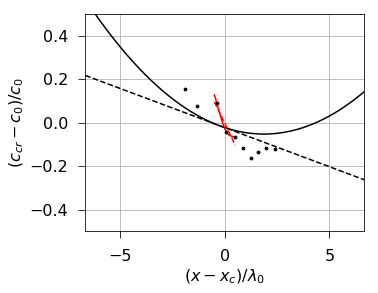

In [104]:
n=3000
scaling=1
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2)
           +(ccr_grad_2ord[n]*x_axis+0.5*ccr_lapl_2ord[n]*x_axis**2)/((k0*Spread_x[n])**4))/c0,'k')
ax.plot(x_axis*k0/(2*np.pi),((ccr_1ord+ccr_grad_1ord[n]*x_axis)/((k0*Spread_x[n])**2))/c0,'--k')
ax.plot(xnew*k0/(2*np.pi),(np.array(c_spl[n])-c0/2)/c0,'-r')
ax.plot(xnew*k0/(2*np.pi),(LM.fit(np.array([xnew]).T,c_spl[n]).predict(np.array([xnew]).T)-c0/2)/c0,'--r')
for m in range(len(extrema)):
    if extrema[m][1]==n:
        ax.plot(x_axis[extrema[m][0]]*k0/(2*np.pi),scaling*(extr_speed1[m]-c0/2)/c0,'ok',markersize=2.8,label='c1='+str(extr_speed1[m]))
ax.set_ylim(-0.5,0.5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('$(x-x_c)/\lambda_0$',fontsize=16);
ax.set_ylabel("$(c_{cr}-c_0)/c_0$",fontsize=16);
ax.set_xlim(-1500*k0/(2*np.pi),1500*k0/(2*np.pi));#ax.set_ylim(-0.4,0.4)
plt.grid()
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches(5,4)
plt.show()

In [105]:
temps_depart=time.time()

c_grad_mes=np.zeros(len(t_axis)-2)
dist0=np.max(x_axis)*10**2
LM=linear_model.LinearRegression()
for n in range(len(t_axis)-2):
    if (n%int((len(t_axis)-2)/100))==0:
        print('computing='+str(int(100*n/(len(t_axis)-2)))
    +'%, computing time = '+str(int(round(time.time()-temps_depart,0)))+'s')
    m0=0
    dist=dist0
    for m in range(len(extrema)):
        if (extrema[m][1]==n
            and np.abs(x_axis[extrema[m][0]])<dist):
            dist=np.abs(x_axis[extrema[m][0]])
            m0=m
            
    y=np.array([  
                extr_speed1[m0-1] , 
                extr_speed1[m0] ,
                extr_speed1[m0+1]  
               ])
    
    X=np.array([ 
                [1,x_axis[extrema[m0-1][0]],x_axis[extrema[m0-1][0]]**2] , 
                [1,x_axis[extrema[m0][0]],x_axis[extrema[m0][0]]**2] ,
                [1,x_axis[extrema[m0+1][0]],x_axis[extrema[m0+1][0]]**2] 
               ])   # i just realized that the "ones" are useless since the regression done by scikit
                    # has its own constant term...
    
    c_grad_mes[n]=LM.fit(X,y).coef_[1]
    #del X, y
temps_grad=time.time()-temps_depart  

computing=0%, computing time = 0s
computing=0%, computing time = 1s
computing=1%, computing time = 2s
computing=2%, computing time = 3s
computing=3%, computing time = 3s
computing=4%, computing time = 4s
computing=5%, computing time = 5s
computing=6%, computing time = 6s
computing=7%, computing time = 7s
computing=8%, computing time = 8s
computing=9%, computing time = 9s
computing=10%, computing time = 9s
computing=11%, computing time = 10s
computing=12%, computing time = 11s
computing=13%, computing time = 12s
computing=14%, computing time = 13s
computing=15%, computing time = 14s
computing=16%, computing time = 14s
computing=17%, computing time = 15s
computing=18%, computing time = 16s
computing=19%, computing time = 17s
computing=20%, computing time = 18s
computing=21%, computing time = 18s
computing=22%, computing time = 19s
computing=23%, computing time = 20s
computing=24%, computing time = 21s
computing=25%, computing time = 22s
computing=26%, computing time = 23s
computing=27%, 

In [36]:
# position of the largest crest/trough in space, over time
eta_abs_argmax=np.argmax(np.abs(eta1),axis=0)
# criterion for having the largest crest/trough close enough to the center of the WP
thresh_center= 4 * ((2*np.pi)/k0) * dt/(2*tp) 

In [37]:
temps_depart=time.time()
c_grad_mes=[]
t_grad_mes=[]
dist0=np.max(x_axis)*10**2
LM=linear_model.LinearRegression()

for n in range(len(t_axis)):
#    if (n%int((len(t_axis)-2)/100))==0:
#        print('computing='+str(int(100*n/(len(t_axis)-2)))
#    +'%, computing time = '+str(int(round(time.time()-temps_depart,0)))+'s')
    
    if (-thresh_center/2<x_axis[eta_abs_argmax[n]]
        and x_axis[eta_abs_argmax[n]]<thresh_center/2):
        
        t_grad_mes.append(t_axis[n])
        
        m0=0
        dist=dist0
        for m in range(len(extrema)):
            if (extrema[m][1]==n
                and np.abs(x_axis[extrema[m][0]])<dist):
                dist=np.abs(x_axis[extrema[m][0]])
                m0=m
            
        y=np.array([  
                extr_speed1[m0-1] , 
                extr_speed1[m0] ,
                extr_speed1[m0+1]  
                   ])
    
        X=np.array([ 
                [1,x_axis[extrema[m0-1][0]],x_axis[extrema[m0-1][0]]**2] , 
                [1,x_axis[extrema[m0][0]],x_axis[extrema[m0][0]]**2] ,
                [1,x_axis[extrema[m0+1][0]],x_axis[extrema[m0+1][0]]**2] 
                   ])
    
        c_grad_mes.append(LM.fit(X,y).coef_[1])
        del X, y
temps_grad=time.time()-temps_depart  

In [38]:
c_grad_agg=[] # "agg" stands for "agglomerate"
t_grad_agg=[]
c_=[c_grad_mes[0]]
t_=[t_grad_mes[0]]
for n in range(len(t_grad_mes)-1):
    if t_grad_mes[n+1]-t_grad_mes[n]<2*dt:
        c_.append(c_grad_mes[n+1])
        t_.append(t_grad_mes[n+1])
    else:
        c_grad_agg.append(np.mean(np.array(c_)))
        t_grad_agg.append(np.mean(np.array(t_)))
        c_=[c_grad_mes[n+1]]
        t_=[t_grad_mes[n+1]]
    if n+1==len(t_grad_mes)-1:
        c_grad_agg.append(np.mean(np.array(c_)))
        t_grad_agg.append(np.mean(np.array(t_)))

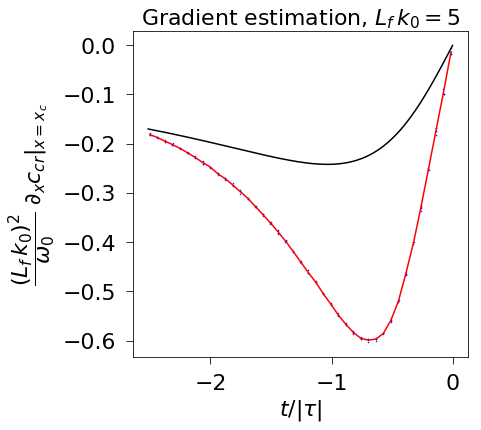

In [39]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(np.array(t_grad_mes)/np.abs(tau),np.array(c_grad_mes)*L*L*k0*k0/(c0*k0),'.b',markersize=1)
ax.plot(np.array(t_grad_agg)/np.abs(tau),np.array(c_grad_agg)*L*L*k0*k0/(c0*k0),'-r')
#ax.set_xlim([-2,0])
#ax.set_ylim([-1.2,0.1])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

In [40]:
ccr_grad_1ord_=(-c0+cg0)*k0*np.array(t_grad_agg)/tau
Spread_x_=np.sqrt(L**2+(L**(-2))*(par2om*np.array(t_grad_agg))**2)
c_grad_expect_=ccr_grad_1ord_/((k0*Spread_x_)**2)

In [41]:
A*np.sqrt(2),4*A

(0.16817928305074292, 0.47568284600108846)

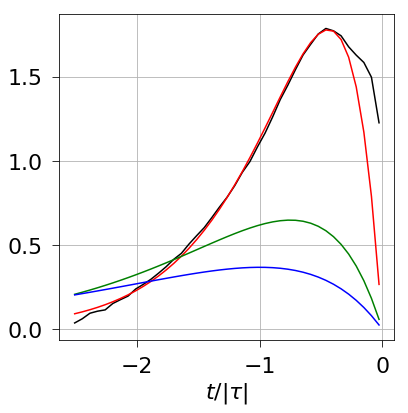

In [84]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
tsurtau=t_axis[:-2]/tau
#ax.plot(tsurtau,c_grad_expect*(1+5*A*np.sqrt(2)*(tsurtau/(1+tsurtau**2))**2 )*L*L*k0*k0/(c0*k0),'--k')
tsurtau_=np.array(t_grad_agg)/tau
ax.plot(-tsurtau_,np.array(c_grad_agg)/c_grad_expect_-1,'k')
#ax.plot(-tsurtau_,(1-tsurtau_*4*A))
#ax.plot(-tsurtau_,2*3*tsurtau_/(1+tsurtau_**2)**3)
ax.plot(-tsurtau_,11*tsurtau_*np.exp(-tsurtau_/0.44),'r')
ax.plot(-tsurtau_,2.35*tsurtau_*np.exp(-tsurtau_/0.75),'g')
ax.plot(-tsurtau_,tsurtau_*np.exp(-tsurtau_),'b')
#ax.plot(-tsurtau_,(tsurtau_/(1+tsurtau_**2))*np.pi*2*np.sqrt(2)*A*np.sqrt(2))
#ax.set_xlim([-2,0])
#ax.set_ylim([-1.2,0.1])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
#ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
#plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
plt.grid()
fig.set_size_inches([6,6])
plt.show()

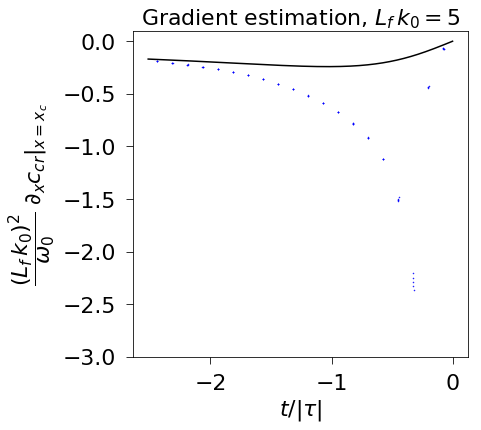

In [60]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(np.array(t_grad_mes)/np.abs(tau),np.array(c_grad_mes)*L*L*k0*k0/(c0*k0),'.b',markersize=1)
#ax.set_xlim([-2,0])
ax.set_ylim([-3,0.1])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

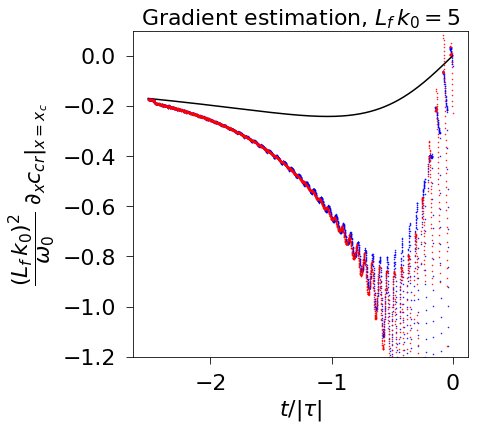

In [107]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_mes*L*L*k0*k0/(c0*k0),'.b',markersize=1)
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_mes_spl*L*L*k0*k0/(c0*k0),'.r',markersize=1)
#ax.set_xlim([-2,0])
ax.set_ylim([-1.2,0.1])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

In [110]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

/home/administrateur/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


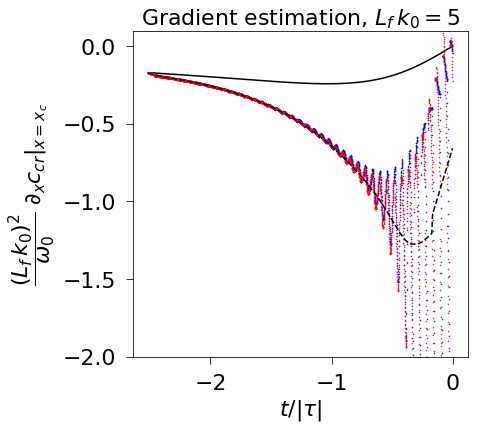

In [123]:

plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_mes*L*L*k0*k0/(c0*k0),'.b',markersize=1)
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_mes_spl*L*L*k0*k0/(c0*k0),'.r',markersize=1)
ax.plot(t_axis[:-2]/np.abs(tau),
        lowess(c_grad_mes_spl*L*L*k0*k0/(c0*k0), t_axis[:-2]/np.abs(tau), frac=1./10, return_sorted=False),
        '--k',markersize=1)
#ax.set_xlim([-2,0])
ax.set_ylim([-2,0.1])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

In [136]:
# smoothing taking the median
c_grad_mes_smooth=np.zeros(len(t_axis)-2)
n_smooth=200*2
for n in range(len(t_axis)-2):
    n_low=int(max(0,n-n_smooth/2)); n_high=int(min(len(t_axis)-3,n+n_smooth/2))
    c_grad_mes_smooth[n]=np.median(c_grad_mes_spl[n_low:n_high])

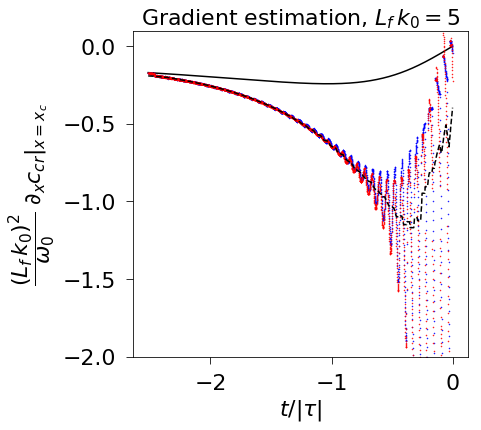

In [137]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_mes*L*L*k0*k0/(c0*k0),'.b',markersize=1)
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_mes_spl*L*L*k0*k0/(c0*k0),'.r',markersize=1)
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_mes_smooth*L*L*k0*k0/(c0*k0),'--k',markersize=1)
#ax.set_xlim([-2,0])
ax.set_ylim([-2,0.1])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

--------------
Computing the amplitude over time

In [42]:
#A_adim=np.amax(np.abs(U_new[nt1:nt2+1:dnt,nx1:nx2+1]),axis=1)
A_adim=np.amax(np.abs(U_new),axis=1)

In [43]:
np.argmax(A_adim),len(A_adim)

(3429, 3431)

Computing the width at focus

In [44]:
def gauss(x, *p):
    a, mu, sigma = p
    return a*np.exp(-(x-mu)**2/(2*sigma**2))
from scipy.optimize import curve_fit
p0=[1,0,1]

In [45]:
#fit=curve_fit(gauss,x_axis,np.abs(U_new[nt2,nx1:nx2+1]),p0=p0)
fit=curve_fit(gauss,x_axis,np.abs(U_new[-1,:]),p0=p0)
L_foc=fit[0][2]

In [46]:
fit

(array([ 1.64999296e-01, -2.54447626e-05,  9.02553645e+01]),
 array([[ 2.13205579e-08,  2.59710081e-11, -7.77515084e-06],
        [ 2.59710081e-11,  8.50563103e-03, -1.06290909e-07],
        [-7.77515084e-06, -1.06290909e-07,  8.50629311e-03]]))

In [47]:
k0*L_foc

2.5223262630906067

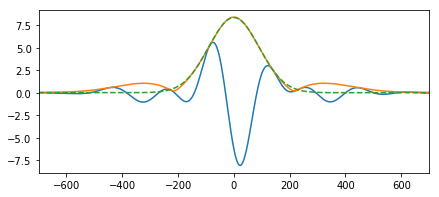

In [130]:
'''plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
n=-1; 
ax.plot(x_axis,eta1[:,n])
ax.plot(x_axis,np.abs(U_new[nt2,nx1:nx2+1])*np.sqrt(2)/k0)
ax.plot(x_axis,gauss(x_axis,fit[0][0],fit[0][1],fit[0][2])*np.sqrt(2)/k0,'--')
ax.set_xlim([-700,700])
fig.set_size_inches([7,3])
plt.show()'''

--------------
### Making the prediction

In [48]:
def gradient_fit( time , t0 , Tau ):
    return 2*((time-t0)/(Tau**2+(time-t0)**2))

def gradient_fit_addNL( time , t0 , Tau , addNL ):
    return 2*addNL*((time-t0)/(Tau**2+(time-t0)**2))

def gradient_fit22( time , t0 , Tau ):
    return 2*((time-t0)/(Tau**2+(time-t0)**2))*( 1-3.25/((k0*c0*Tau/4)*(1+((time-t0)/Tau)**2)) )

In [49]:
len(t_grad_agg)

41

In [52]:
temps_depart=time.time()

STD_FIT=np.std(c_grad_mes_spl-c_grad_expect)

nstart=9
Nts=len(t_grad_agg)
# tfoc, A_ratio and L are predicted values based on the best fit
tfoc=np.zeros(Nts)
tau_abs=np.zeros(Nts)
A_ratio=np.zeros(Nts)
L_estim=np.zeros(Nts)
cov=np.full((Nts,2,2),np.inf)

for nend in range(nstart+3,Nts):
    n=nend-nstart-3
#    popt, pcov = curve_fit(gradient_fit22, np.array(t_grad_agg)[nstart:nend], np.array(c_grad_agg)[nstart:nend],p0=[0,10*2*np.pi/(k0*c0)]
#                       ,sigma=STD_FIT*np.ones(nend-nstart))
    popt, pcov = curve_fit(gradient_fit22, np.array(t_grad_agg)[nstart:nend], np.array(c_grad_agg)[nstart:nend],p0=[0,10*2*np.pi/(k0*c0)]
                       ,sigma=STD_FIT*np.ones(nend-nstart),bounds=([-np.inf,1/w0],[np.inf,40000/w0]))
    tfoc[nend]=popt[0]
    tau_abs[nend]=np.abs(popt[1])
    L_estim[nend]=(c0*np.abs(popt[1])/(4*k0))**0.5
    A_ratio[nend]=(1+((np.array(t_grad_agg)[nend]+popt[0])/popt[1])**2)**0.25
    cov[nend,:,:]=pcov

temps_fit=time.time()-temps_depart  

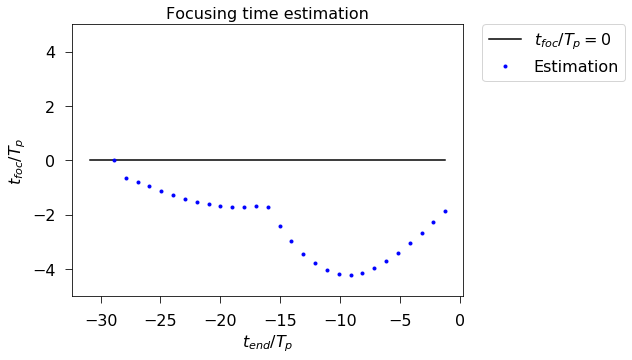

In [53]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(np.array(t_grad_agg)[nstart:nend]*w0/(2*np.pi),np.zeros(len(t_axis[nstart:nend])),'k',label=r'$t_{foc}/T_p=0$')
ax.plot(np.array(t_grad_agg)[nstart+2:nend]*w0/(2*np.pi),tfoc[nstart+2:nend]*c0*k0/(2*np.pi),'.b',
        label='Estimation')
ax.set_title('Focusing time estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel('$t_{foc}/T_p$',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
ax.set_ylim([-5,5])
#ax.set_xlim([-2.5,0])
fig.set_size_inches([7,5])
plt.show()

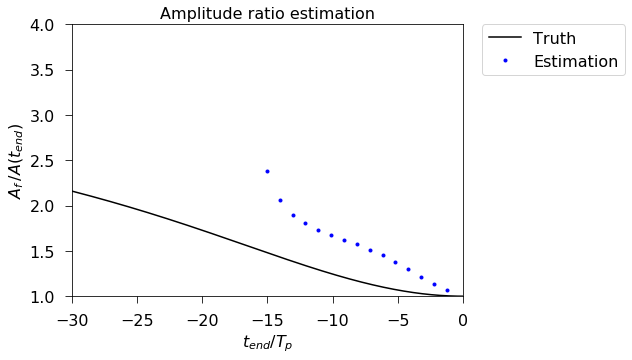

In [54]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis*w0/(2*np.pi),(A_adim/A_adim[-1])**(-1),'k',
        label='Truth')
ax.plot(np.array(t_grad_agg)[nstart+2:nend]*w0/(2*np.pi),A_ratio[nstart+2:nend],'.b',label='Estimation')
ax.set_ylim([1,4])
ax.set_xlim([-30,0])
ax.set_title('Amplitude ratio estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel(r'$A_{f}\, /A(t_{end})$',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches([7,5])
plt.show()

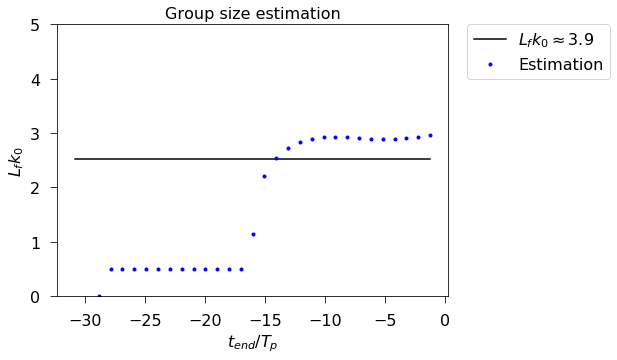

In [55]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(np.array(t_grad_agg)[nstart:nend]*w0/(2*np.pi),k0*L_foc*np.ones(len(t_axis[nstart:nend])),'k',label=r'$L_{f}k_0\approx 3.9$')
ax.plot(np.array(t_grad_agg)[nstart+2:nend]*w0/(2*np.pi),k0*L_estim[nstart+2:nend],'.b',label='Estimation')
ax.set_ylim([3.8,4.1])
ax.set_ylim([0,5])
#ax.set_xlim([-2,0])
ax.set_title('Group size estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel(r'$L_{f}k_0 $',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches([7,5])
plt.show()

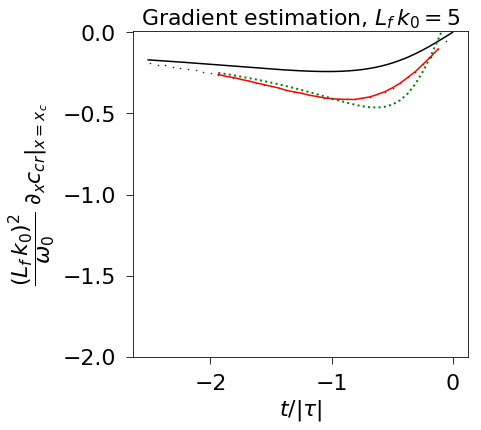

In [64]:
#ne=nstart+1600
ne=39
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(np.array(t_grad_agg)/np.abs(tau),np.array(c_grad_agg)*L*L*k0*k0/(c0*k0),'.k',markersize=1)
ax.plot(np.array(t_grad_agg)[nstart:ne]/np.abs(tau),np.array(c_grad_agg)[nstart:ne]*L*L*k0*k0/(c0*k0),'r',markersize=1)
#ax.plot(t_axis[nstart:ne]/np.abs(tau),gradient_fit22(t_axis[nstart:ne],tfoc[ne],tau_abs[ne])*L*L*k0*k0/(c0*k0),':k',markersize=1)
ax.plot(np.array(t_grad_agg)[nstart:]/np.abs(tau),
        gradient_fit(np.array(t_grad_agg)[nstart:],tfoc[ne],tau_abs[ne])*L*L*k0*k0/(c0*k0),':g',linewidth=2)
#ax.set_xlim([-2,1])
ax.set_ylim([-2,0.01])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

In [65]:
temps_depart=time.time()

STD_FIT=np.std(c_grad_mes_spl-c_grad_expect)

nstart=9
Nts=len(t_grad_agg)
# tfoc, A_ratio and L are predicted values based on the best fit
tfoc=np.zeros(Nts)
tau_abs=np.zeros(Nts)
A_ratio=np.zeros(Nts)
L_estim=np.zeros(Nts)
cov=np.full((Nts,2,2),np.inf)

for nend in range(nstart+3,Nts):
    n=nend-nstart-3
#    popt, pcov = curve_fit(gradient_fit, np.array(t_grad_agg)[nstart:nend], np.array(c_grad_agg)[nstart:nend],p0=[0,10*2*np.pi/(k0*c0)]
#                       ,sigma=STD_FIT*np.ones(nend-nstart))
    popt, pcov = curve_fit(gradient_fit22, np.array(t_grad_agg)[nstart:nend], np.array(c_grad_agg)[nstart:nend],p0=[0,10*2*np.pi/(k0*c0)]
                       ,sigma=STD_FIT*np.ones(nend-nstart),bounds=([-np.inf,1/w0],[np.inf,40000/w0]))
    tfoc[nend]=popt[0]
    tau_abs[nend]=np.abs(popt[1])
    L_estim[nend]=(c0*np.abs(popt[1])/(4*k0))**0.5
    A_ratio[nend]=(1+((np.array(t_grad_agg)[nend]+popt[0])/popt[1])**2)**0.25
    cov[nend,:,:]=pcov

temps_fit=time.time()-temps_depart  

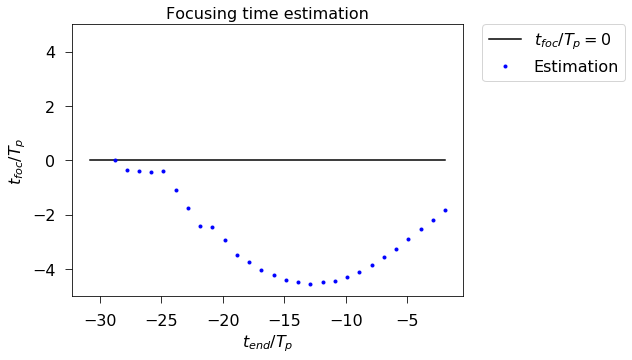

In [66]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(np.array(t_grad_agg)[nstart:nend]*w0/(2*np.pi),np.zeros(len(t_axis[nstart:nend])),'k',label=r'$t_{foc}/T_p=0$')
ax.plot(np.array(t_grad_agg)[nstart+2:nend]*w0/(2*np.pi),tfoc[nstart+2:nend]*c0*k0/(2*np.pi),'.b',
        label='Estimation')
ax.set_title('Focusing time estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel('$t_{foc}/T_p$',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
ax.set_ylim([-5,5])
#ax.set_xlim([-2.5,0])
fig.set_size_inches([7,5])
plt.show()

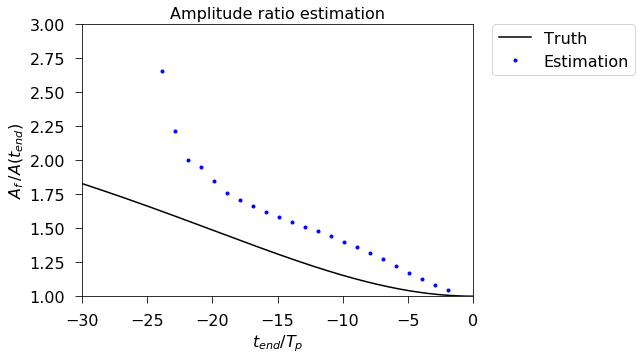

In [67]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis*w0/(2*np.pi),(A_adim/A_adim[-1])**(-1),'k',
        label='Truth')
ax.plot(np.array(t_grad_agg)[nstart+2:nend]*w0/(2*np.pi),A_ratio[nstart+2:nend],'.b',label='Estimation')
ax.set_ylim([1,3])
ax.set_xlim([-30,0])
ax.set_title('Amplitude ratio estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel(r'$A_{f}\, /A(t_{end})$',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches([7,5])
plt.show()

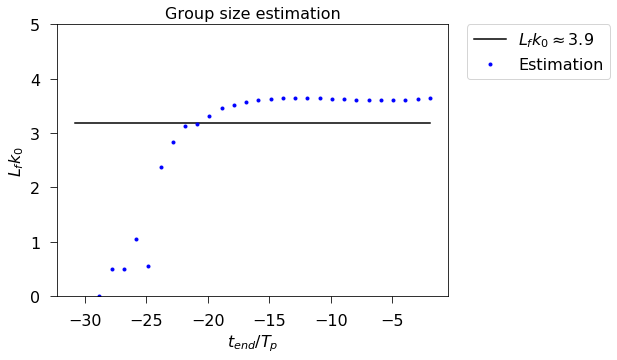

In [68]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(np.array(t_grad_agg)[nstart:nend]*w0/(2*np.pi),k0*L_foc*np.ones(len(t_axis[nstart:nend])),'k',label=r'$L_{f}k_0\approx 3.9$')
ax.plot(np.array(t_grad_agg)[nstart+2:nend]*w0/(2*np.pi),k0*L_estim[nstart+2:nend],'.b',label='Estimation')
ax.set_ylim([3.8,4.1])
ax.set_ylim([0,5])
#ax.set_xlim([-2,0])
ax.set_title('Group size estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel(r'$L_{f}k_0 $',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches([7,5])
plt.show()

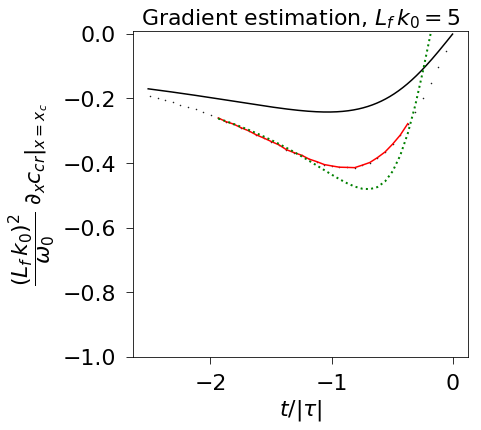

In [69]:
#ne=nstart+1600
ne=35
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(np.array(t_grad_agg)/np.abs(tau),np.array(c_grad_agg)*L*L*k0*k0/(c0*k0),'.k',markersize=1)
ax.plot(np.array(t_grad_agg)[nstart:ne]/np.abs(tau),np.array(c_grad_agg)[nstart:ne]*L*L*k0*k0/(c0*k0),'r',markersize=1)
#ax.plot(t_axis[nstart:ne]/np.abs(tau),gradient_fit22(t_axis[nstart:ne],tfoc[ne],tau_abs[ne])*L*L*k0*k0/(c0*k0),':k',markersize=1)
ax.plot(np.array(t_grad_agg)[nstart:]/np.abs(tau),
        gradient_fit(np.array(t_grad_agg)[nstart:],tfoc[ne],tau_abs[ne])*L*L*k0*k0/(c0*k0),':g',linewidth=2)
#ax.set_xlim([-2,1])
ax.set_ylim([-1,0.01])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

--------------
### Making the prediction

In [156]:
def gradient_fit_addNL( time , t0 , Tau , addNL ):
    return 2*addNL*((time-t0)/(Tau**2+(time-t0)**2))

def gradient_fit22( time , t0 , Tau ):
    return 2*((time-t0)/(Tau**2+(time-t0)**2))*( 1-3.25/((k0*c0*Tau/4)*(1+((time-t0)/Tau)**2)) )

In [131]:
n=1710
len(t_axis),0.5*w0*t_axis[n]/np.pi,2*np.pi/w0,t_axis[n]/60

(3430, -20.055, 12.0, -4.011)

In [164]:
temps_depart=time.time()

STD_FIT=np.std(c_grad_mes-c_grad_expect)

nstart=1715
Nts=len(t_axis)
# tfoc, A_ratio and L are predicted values based on the best fit
tfoc=np.zeros(Nts-3)
tau_abs=np.zeros(Nts-3)
A_ratio=np.zeros(Nts-3)
addNL_estim=np.zeros(Nts-3)
L_estim=np.zeros(Nts-3)
cov=np.full((Nts-3,3,3),np.inf)

for nend in range(nstart+40,Nts-3):
    n=nend-nstart-40
    if (n%int((Nts-nstart-6)/100))==0:
        print('computing='+str(int(100*n/(Nts-nstart-6)))
    +'%, computing time = '+str(int(round(time.time()-temps_depart,0)))+'s')
    popt, pcov = curve_fit(gradient_fit_addNL, t_axis[nstart:nend], c_grad_mes[nstart:nend],
                        p0=[0,10*2*np.pi/(k0*c0),1],sigma=STD_FIT*np.ones(nend-nstart))
    tfoc[nend]=popt[0]
    tau_abs[nend]=np.abs(popt[1])
    addNL_estim[nend]=popt[2]
    L_estim[nend]=(c0*np.abs(popt[1])/(4*k0))**0.5
    A_ratio[nend]=(1+((t_axis[nend]+popt[0])/popt[1])**2)**0.25
    cov[nend,:,:]=pcov

temps_fit=time.time()-temps_depart  

computing=0%, computing time = 0s


/home/administrateur/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


computing=0%, computing time = 0s
computing=1%, computing time = 1s
computing=2%, computing time = 1s
computing=3%, computing time = 1s
computing=4%, computing time = 1s
computing=5%, computing time = 1s
computing=6%, computing time = 1s
computing=7%, computing time = 1s
computing=8%, computing time = 1s
computing=9%, computing time = 1s
computing=10%, computing time = 1s
computing=11%, computing time = 1s
computing=12%, computing time = 2s
computing=13%, computing time = 2s
computing=14%, computing time = 2s
computing=15%, computing time = 2s
computing=16%, computing time = 2s
computing=17%, computing time = 2s
computing=18%, computing time = 2s
computing=19%, computing time = 2s
computing=20%, computing time = 2s
computing=21%, computing time = 2s
computing=22%, computing time = 2s
computing=23%, computing time = 2s
computing=24%, computing time = 3s
computing=25%, computing time = 3s
computing=26%, computing time = 3s
computing=27%, computing time = 3s
computing=28%, computing time 

In [163]:
nstart+30,nend

(1745, 1746)

In [172]:
t_axis[3000]*w0/(2*np.pi)

-5.004999999999999

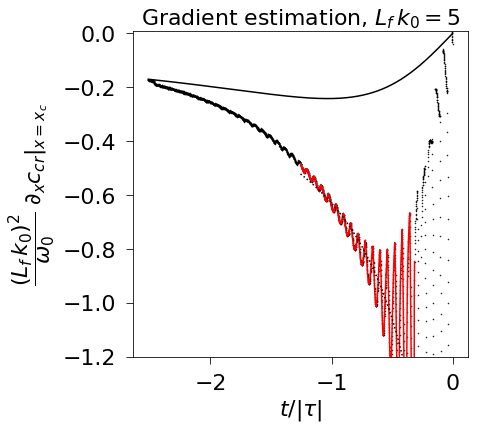

In [173]:
#ne=nstart+1600
ne=3000
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[:-2]/np.abs(tau),
        c_grad_expect*L*L*k0*k0/(c0*k0),'-k')
ax.plot(t_axis[:-2]/np.abs(tau),c_grad_mes*L*L*k0*k0/(c0*k0),'.k',markersize=1)
ax.plot(t_axis[nstart:ne]/np.abs(tau),c_grad_mes[nstart:ne]*L*L*k0*k0/(c0*k0),'r',markersize=1)
#ax.plot(t_axis[nstart:ne]/np.abs(tau),gradient_fit22(t_axis[nstart:ne],tfoc[ne],tau_abs[ne])*L*L*k0*k0/(c0*k0),':k',markersize=1)
ax.plot(t_axis[nstart:ne]/np.abs(tau),
        gradient_fit_addNL(t_axis[nstart:ne],tfoc[ne],tau_abs[ne],addNL_estim[ne])*L*L*k0*k0/(c0*k0),':k',markersize=1)
#ax.set_xlim([-2,0])
ax.set_ylim([-1.2,0.01])
ftsz=22
ax.set_xlabel(r'$t/ |\tau|$',fontsize=ftsz);
ax.set_ylabel(r"$\dfrac{(L_f\, k_0)^2}{ \omega_0} \; \partial_x c_{cr}|_{x=x_c}$",fontsize=ftsz)
plt.title(r'Gradient estimation, $L_f\, k_0=5$',fontsize=ftsz)
ax.tick_params(length=7,labelsize=ftsz,direction='out',pad=10)
fig.set_size_inches([6,6])
plt.show()

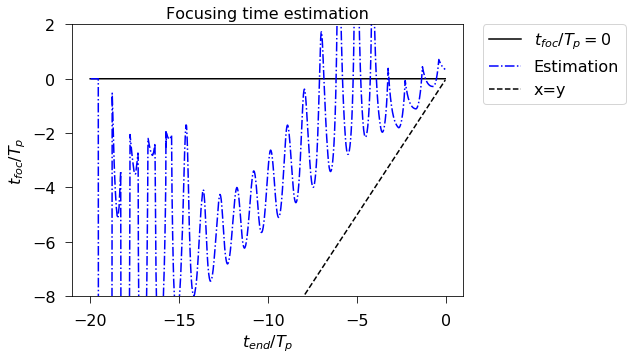

In [166]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[nstart:nend]*w0/(2*np.pi),np.zeros(len(t_axis[nstart:nend])),'k',label=r'$t_{foc}/T_p=0$')
ax.plot(t_axis[nstart+2:nend]*w0/(2*np.pi),tfoc[nstart+2:nend]*c0*k0/(2*np.pi),'-.b',
        label='Estimation')
ax.plot(t_axis[nstart+2:nend]*w0/(2*np.pi),t_axis[nstart+2:nend]*w0/(2*np.pi),'--k',
        label='x=y')
ax.set_title('Focusing time estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel('$t_{foc}/T_p$',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
ax.set_ylim([-8,2])
#ax.set_xlim([-2.5,0])
fig.set_size_inches([7,5])
plt.show()

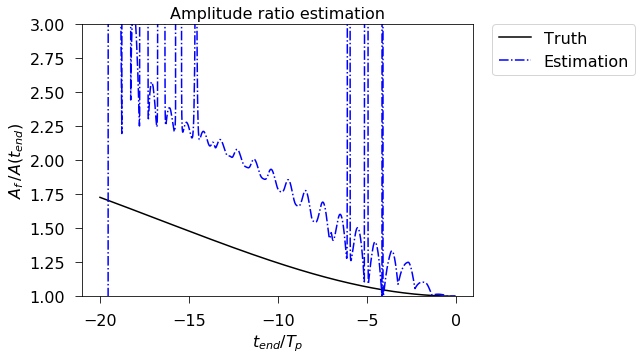

In [167]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
#ax.plot(t_axis[nstart:nend]/np.abs(tau),(1+(t_axis[nstart:nend]/tau)**2)**0.25,'k',
#        label=r'$A_{f}\, /A(t_{end})=\left(1+\left(t_{end}/\tau\right)^2\right)^{1/4}$')
ax.plot(t_axis[nstart:nend]*w0/(2*np.pi),(A_adim[nstart:nend]/A_adim[nend])**(-1),'k',
        label='Truth')
ax.plot(t_axis[nstart+2:nend]*w0/(2*np.pi),A_ratio[nstart+2:nend],'-.b',label='Estimation')
ax.set_ylim([1,3])
#ax.set_xlim([-2.5,0])
ax.set_title('Amplitude ratio estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel(r'$A_{f}\, /A(t_{end})$',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches([7,5])
plt.show()

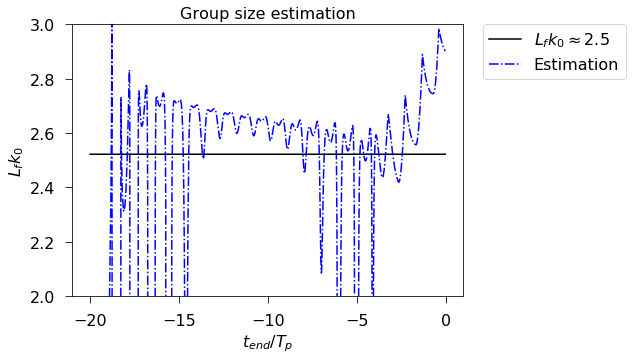

In [168]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[nstart:nend]*w0/(2*np.pi),k0*L_foc*np.ones(len(t_axis[nstart:nend])),'k',label=r'$L_{f}k_0\approx 2.5$')
ax.plot(t_axis[nstart+2:nend]*w0/(2*np.pi),k0*L_estim[nstart+2:nend],'-.b',label='Estimation')
ax.set_ylim([2,3])
#ax.set_xlim([-2,0])
ax.set_title('Group size estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel(r'$L_{f}k_0 $',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches([7,5])
plt.show()

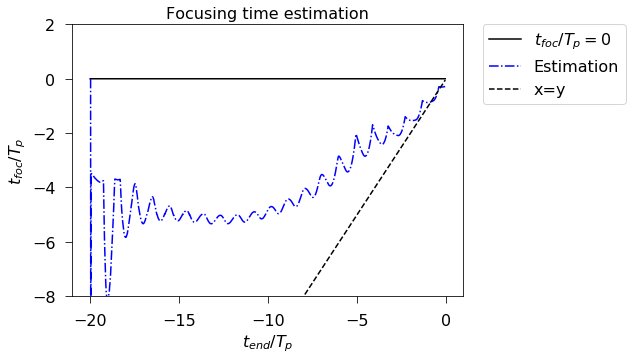

In [139]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[nstart:nend]*w0/(2*np.pi),np.zeros(len(t_axis[nstart:nend])),'k',label=r'$t_{foc}/T_p=0$')
ax.plot(t_axis[nstart+2:nend]*w0/(2*np.pi),tfoc[nstart+2:nend]*c0*k0/(2*np.pi),'-.b',
        label='Estimation')
ax.plot(t_axis[nstart+2:nend]*w0/(2*np.pi),t_axis[nstart+2:nend]*w0/(2*np.pi),'--k',
        label='x=y')
ax.set_title('Focusing time estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel('$t_{foc}/T_p$',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
ax.set_ylim([-8,2])
#ax.set_xlim([-2.5,0])
fig.set_size_inches([7,5])
plt.show()

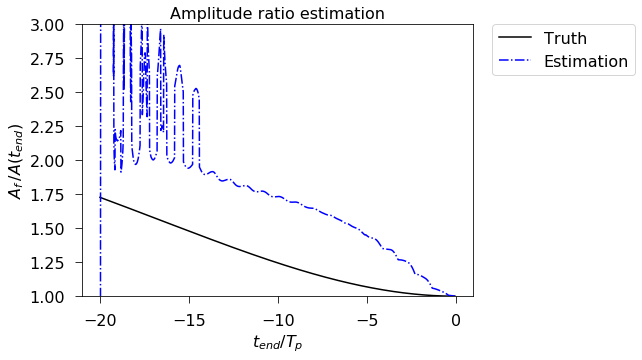

In [136]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
#ax.plot(t_axis[nstart:nend]/np.abs(tau),(1+(t_axis[nstart:nend]/tau)**2)**0.25,'k',
#        label=r'$A_{f}\, /A(t_{end})=\left(1+\left(t_{end}/\tau\right)^2\right)^{1/4}$')
ax.plot(t_axis[nstart:nend]*w0/(2*np.pi),(A_adim[nstart:nend]/A_adim[nend])**(-1),'k',
        label='Truth')
ax.plot(t_axis[nstart+2:nend]*w0/(2*np.pi),A_ratio[nstart+2:nend],'-.b',label='Estimation')
ax.set_ylim([1,3])
#ax.set_xlim([-2.5,0])
ax.set_title('Amplitude ratio estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel(r'$A_{f}\, /A(t_{end})$',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches([7,5])
plt.show()

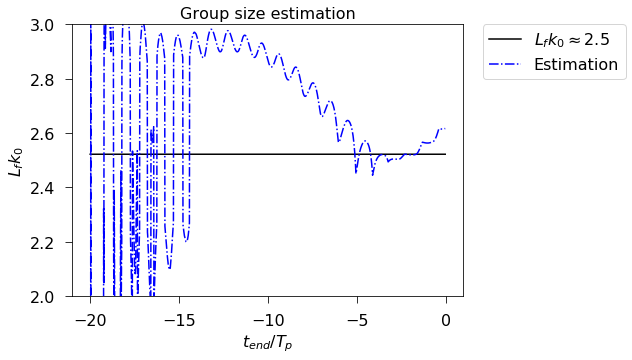

In [138]:
plt.clf(); fig=plt.figure(); fig.add_axes(); ax=fig.add_subplot(111)
ax.plot(t_axis[nstart:nend]*w0/(2*np.pi),k0*L_foc*np.ones(len(t_axis[nstart:nend])),'k',label=r'$L_{f}k_0\approx 2.5$')
ax.plot(t_axis[nstart+2:nend]*w0/(2*np.pi),k0*L_estim[nstart+2:nend],'-.b',label='Estimation')
ax.set_ylim([2,3])
#ax.set_xlim([-2,0])
ax.set_title('Group size estimation',fontsize=16)
ax.set_xlabel(r'$t_{end}/T_p$',fontsize=16)
ax.set_ylabel(r'$L_{f}k_0 $',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=16)
ax.tick_params(length=7,labelsize=16,direction='out',pad=10)
fig.set_size_inches([7,5])
plt.show()